In [ ]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [14]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [15]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [ ]:
def adaptive_kdj_factor(df, volatility_window=20):
    # 1. Â¢ûÂä†‰ª∑Ê†ºËøáÊª§ - ÈÅøÂÖçÂú®‰ΩéÊ≥¢Âä®Êúü‰∫ßÁîüÂô™Èü≥
    returns = np.log(df['close']).diff()
    vol = returns.rolling(volatility_window, min_periods=1).std()
    vol = np.where(np.isinf(vol), np.nan, vol)  # ÊõøÊç¢ inf
    vol = pd.Series(vol, index=df.index).ffill().bfill().fillna(0.01)
    
    # 2. ‰ºòÂåñËá™ÈÄÇÂ∫îÈÄªËæë - ÂºïÂÖ•ÈùûÁ∫øÊÄßÁº©Êîæ
    scaled_vol = (vol * 100).clip(5, 20)
    # Â¢ûÂä†ÂØπÈ´òÊ≥¢Âä®Â∏ÇÂú∫ÁöÑÊïèÊÑüÊÄß
    n_period = np.where(scaled_vol > 15, 
                        scaled_vol * 1.4, 
                        scaled_vol * 0.6)
    n_period = np.clip(n_period, 5, 25).astype(int)
    
    # 3. ÊîπËøõÊûÅÂÄºËÆ°ÁÆó - Â¢ûÂä†ÊùÉÈáçË°∞Âáè
    periods = list(range(5, 26))  # 5Âà∞25
    min_vals = []
    max_vals = []
    
    for p in periods:
        # ÊåáÊï∞Ë°∞ÂáèÂä†ÊùÉÊúÄÂ∞èÂÄº
        min_roll = df['low'].rolling(p, min_periods=1).min()
        min_ewm = min_roll.ewm(span=max(1, p//2), adjust=False).mean()
        min_vals.append(min_ewm)
        
        # ÊåáÊï∞Ë°∞ÂáèÂä†ÊùÉÊúÄÂ§ßÂÄº
        max_roll = df['high'].rolling(p, min_periods=1).max()
        max_ewm = max_roll.ewm(span=max(1, p//2), adjust=False).mean()
        max_vals.append(max_ewm)
    
    min_df = pd.DataFrame(dict(zip(periods, min_vals)), index=df.index)
    max_df = pd.DataFrame(dict(zip(periods, max_vals)), index=df.index)
    
    # 4. Âä®ÊÄÅÈÄâÊã©Á™óÂè£
    col_idx = (n_period - 5).clip(0, 20)
    row_idx = np.arange(len(df))
    low_min = min_df.values[row_idx, col_idx]
    high_max = max_df.values[row_idx, col_idx]
    
    # 5. ÊîπËøõRSVËÆ°ÁÆó - ÈÅøÂÖçÈô§‰ª•Èõ∂
    denom = high_max - low_min
    # ‰ΩøÁî® NumPy ÁöÑ where Êõø‰ª£ Pandas ÁöÑ replace
    denom = np.where(denom < 1e-5, 1e-5, denom)  # ÈÅøÂÖçÈô§‰ª•Èõ∂
    
    # 6. ÊîπËøõRSVËÆ°ÁÆó - Â¢ûÂä†Âπ≥ÊªëÂ§ÑÁêÜ
    rsv = 100 * (df['close'].values - low_min) / denom
    rsv = np.clip(rsv, 0, 100)  # ÈôêÂà∂Âú®0-100ËåÉÂõ¥ÂÜÖ
    rsv = pd.Series(rsv, index=df.index).fillna(50)  # Â°´ÂÖÖÁº∫Â§±ÂÄº‰∏∫50
    
    # 7. ÂèåEMAÂπ≥Êªë
    fast_k = rsv.ewm(span=2, adjust=False, min_periods=1).mean()
    slow_k = fast_k.ewm(span=3, adjust=False, min_periods=1).mean()
    
    # 8. ÊîπËøõ‰∏≠ÂøÉÂåñÊñπÊ≥ï - ‰ΩøÁî®ÊªöÂä®‰∏≠‰ΩçÊï∞ÈÅøÂÖçÊûÅÁ´ØÂÄºÂΩ±Âìç
    rolling_median = slow_k.rolling(100, min_periods=1).median().shift(1).fillna(50)
    
    # 9. ÊúÄÁªàÂõ†Â≠êÊûÑÂª∫ - Ê∑ªÂä†ÊñπÂêëÊéßÂà∂ÂíåÂΩí‰∏ÄÂåñ
    factor = (slow_k - rolling_median)
    
    # 10. Â¢ûÂä†Ë∂ãÂäøÂº∫Âåñ - ÁªìÂêàÂä®ÈáèÊñπÂêë
    momentum = df['close'].pct_change(3).fillna(0)
    factor = factor * (1 + np.sign(momentum) * 0.2)
    
    # 11. ÊúÄÁªàÂΩí‰∏ÄÂåñÂ§ÑÁêÜ
    abs_mean = factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    factor = factor / abs_mean
    
    return factor

In [ ]:
def trend_correlation_factor(df, window=20):
    """
    ‰ΩøÁî®Pandas TAÁöÑÁ∫øÊÄßÂõûÂΩíÊñúÁéá‰Ωú‰∏∫Ë∂ãÂäøÂõ†Â≠ê
    """
    # ËÆ°ÁÆóÁ∫øÊÄßÂõûÂΩíÊñúÁéá
    slope = ta.linreg(df['close'], length=window, slope=True)
    return slope

In [ ]:
def rsi_factor(df, period=20):
    # ‰ΩøÁî®Pandas TAÁöÑrsiÂáΩÊï∞
    return ta.rsi(df['close'], length=period)

In [ ]:
def adaptive_kdj_factor_v3(df, volatility_window=20):
    """
    ‰ΩøÁî®Pandas TAÂÆåÂÖ®ÈáçÊûÑÁöÑËá™ÈÄÇÂ∫îKDJÂõ†Â≠ê
    ÁªìÂêàÊ≥¢Âä®ÁéáË∞ÉÊï¥ÂíåEMAÂπ≥Êªë
    """
    # 1. ËÆ°ÁÆóÊ≥¢Âä®ÁéáË∞ÉÊï¥ÁöÑÂë®ÊúüÈïøÂ∫¶
    returns = np.log(df['close']).diff()
    vol = returns.rolling(volatility_window, min_periods=1).std()
    vol = vol.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0.01)
    
    # ÈùûÁ∫øÊÄßÁº©ÊîæÊ≥¢Âä®Áéá
    scaled_vol = (vol * 100).clip(5, 20)
    n_period = np.where(
        scaled_vol > 15, 
        scaled_vol * 1.4, 
        scaled_vol * 0.6
    ).clip(5, 25).astype(int)
    
    # 2. ‰ΩøÁî®Pandas TAËÆ°ÁÆóËá™ÈÄÇÂ∫îKDJ
    # ‰∏∫ÊØè‰∏™‰∏çÂêåÁöÑn_periodËÆ°ÁÆóKDJ
    unique_periods = np.unique(n_period)
    kdj_results = {}
    
    for period in unique_periods:
        kdj = ta.kdj(df['high'], df['low'], df['close'], length=period, signal=3)
        kdj_results[period] = kdj[f'K_{period}_3']  # Âè™ÂèñKÂÄº
    
    # 3. Ê†πÊçÆÊØè‰∏™Êó∂Èó¥ÁÇπÁöÑn_periodÈÄâÊã©ÂØπÂ∫îÁöÑKÂÄº
    k_values = pd.Series(index=df.index, dtype=float)
    for i in range(len(df)):
        period = n_period[i]
        k_values.iloc[i] = kdj_results[period].iloc[i]
    
    # 4. ‰∏≠ÂøÉÂåñÂ§ÑÁêÜ
    rolling_median = k_values.rolling(100, min_periods=1).median().shift(1).fillna(50)
    factor = k_values - rolling_median
    
    # 5. Â¢ûÂä†Ë∂ãÂäøÂº∫Âåñ
    momentum = df['close'].pct_change(3).fillna(0)
    factor = factor * (1 + np.sign(momentum) * 0.2)
    
    # 6. ÊúÄÁªàÂΩí‰∏ÄÂåñ
    abs_mean = factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    return factor / abs_mean

In [ ]:
def kdj_pressure_factor(df, n=9, m=3):
    # ‰ΩøÁî®Pandas TAÁöÑkdjÂáΩÊï∞
    kdj = ta.kdj(df['high'], df['low'], df['close'], length=n, signal=m)
    k = kdj[f'K_{n}_{m}']
    d = kdj[f'D_{n}_{m}']
    j = kdj[f'J_{n}_{m}']
    return (k + d + j) / 3 - 50  # ÂΩí‰∏ÄÂåñÂéãÂäõÂàÜÊï∞

In [ ]:
def j_extreme_factor(df, n=9, m=3):
    # ‰ΩøÁî®Pandas TAÁöÑkdjÂáΩÊï∞
    kdj = ta.kdj(df['high'], df['low'], df['close'], length=n, signal=m)
    j = kdj[f'J_{n}_{m}']
    # SigmoidÂèòÊç¢Âº∫Ë∞ÉÊûÅÁ´ØÂÄº
    return 1 / (1 + np.exp(-0.1 * (j - 50)))

In [ ]:
def macd(df, fast=12, slow=26, signal=9):
    # ‰ΩøÁî®Pandas TAÁöÑmacdÂáΩÊï∞
    macd_result = ta.macd(df['close'], fast=fast, slow=slow, signal=signal)
    return macd_result['MACD_12_26_9'].fillna(0)  # ËøîÂõûMACDÁ∫ø

In [ ]:
def atr(df, period=14):
    # ‰ΩøÁî®Pandas TAÁöÑatrÂáΩÊï∞
    return ta.atr(df['high'], df['low'], df['close'], length=period).fillna(0)

In [ ]:
def optimize_weights(df, factors, target):
    # Create feature matrix X from factors
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    # Remove rows with NaN in X or y
    valid_rows = X.notna().all(axis=1) & y.notna()
    X = X.loc[valid_rows]
    y = y.loc[valid_rows]
    # Check if there's enough data to fit the model
    if len(X) == 0:
        raise ValueError("No valid data remaining after removing NaN values.")
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_

In [ ]:
def improved_factor(df):
    # ‰ΩøÁî®Pandas TAËÆ°ÁÆóÊâÄÊúâÂõ†Â≠ê
    adaptive_kdj = adaptive_kdj_factor(df)
    buy_pressure = df['taker_buy_turnover'] / df['turnover'].replace(0, np.nan).fillna(0)
    macd_diff = macd(df)  # ‰ΩøÁî®Pandas TAÁâàÊú¨
    atr_value = atr(df)  # ‰ΩøÁî®Pandas TAÁâàÊú¨
    
    # ‰ΩøÁî®Pandas TAËÆ°ÁÆóÂÖ∂‰ªñÂõ†Â≠ê
    trend_corr = trend_correlation_factor(df)
    rsi = rsi_factor(df)  # ‰ΩøÁî®Pandas TAÁâàÊú¨
    adaptive_kdj_v3 = adaptive_kdj_factor_v3(df)
    kdj_pressure = kdj_pressure_factor(df)  # ‰ΩøÁî®Pandas TAÁâàÊú¨
    j_extreme = j_extreme_factor(df)  # ‰ΩøÁî®Pandas TAÁâàÊú¨
    
    # Ê†áÂáÜÂåñÊâÄÊúâÂõ†Â≠ê
    factors_to_standardize = {
        'adaptive_kdj': adaptive_kdj,
        'buy_pressure': buy_pressure,
        'macd_diff': macd_diff,
        'atr': atr_value,
        'trend_corr': trend_corr,
        'rsi': rsi,
        'adaptive_kdj_v3': adaptive_kdj_v3,
        'kdj_pressure': kdj_pressure,
        'j_extreme': j_extreme
    }
    
    # ... [Ê†áÂáÜÂåñÂíåÁªÑÂêàÂõ†Â≠êÁöÑ‰ª£Á†Å‰øùÊåÅ‰∏çÂèò] ...
    
    standardized_factors = {}
    for name, factor_series in factors_to_standardize.items():
        # Â§ÑÁêÜÁâπÊÆäÊÉÖÂÜµÔºöj_extremeÂõ†Â≠êËåÉÂõ¥Âú®0-1‰πãÈó¥ÔºåÈúÄË¶ÅÁâπÊÆäÂ§ÑÁêÜ
        if name == 'j_extreme':
            # Â∞Ü0-1ËåÉÂõ¥Êò†Â∞ÑÂà∞-1Âà∞1ËåÉÂõ¥
            factor_series = 2 * (factor_series - 0.5)
        
        # Ê†áÂáÜÂåñÂ§ÑÁêÜ
        mean_val = factor_series.mean()
        std_val = factor_series.std()
        if std_val < 1e-5:
            standardized_factor = factor_series - mean_val
        else:
            standardized_factor = (factor_series - mean_val) / std_val
        
        # Â°´ÂÖÖNaN‰∏∫0
        standardized_factors[name] = standardized_factor.fillna(0)
    
    # 4. ÂÆö‰πâÂõ†Â≠êÂ≠óÂÖ∏ÂíåÁõÆÊ†áÂáΩÊï∞
    factors = {
        'adaptive_kdj': lambda df: standardized_factors['adaptive_kdj'],
        'buy_pressure': lambda df: standardized_factors['buy_pressure'],
        'macd_diff': lambda df: standardized_factors['macd_diff'],
        'atr': lambda df: -standardized_factors['atr'],  # Ë¥üATRÊÉ©ÁΩöÈ´òÊ≥¢Âä®ÊÄß
        'trend_corr': lambda df: standardized_factors['trend_corr'],
        'rsi': lambda df: standardized_factors['rsi'],
        'adaptive_kdj_v3': lambda df: standardized_factors['adaptive_kdj_v3'],
        'kdj_pressure': lambda df: standardized_factors['kdj_pressure'],
        'j_extreme': lambda df: standardized_factors['j_extreme']
    }
    
    # ÁõÆÊ†áÂáΩÊï∞ÔºöÊú™Êù•10ÊúüÊî∂ÁõäÁéá
    target = lambda df: df['close'].pct_change(10).shift(-10)
    
    # 5. ‰ºòÂåñÊùÉÈáç
    weights = optimize_weights(df, factors, target)
    
    # 6. ÁªÑÂêàÂõ†Â≠ê
    combined_factor = sum(weight * factor(df) for weight, factor in zip(weights, factors.values()))
    
    # 7. ÊúÄÁªàÂΩí‰∏ÄÂåñÂ§ÑÁêÜ
    abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    normalized_factor = combined_factor / abs_mean
    
    return normalized_factor

In [17]:
# Âú®evaluator‰∏≠‰ΩøÁî®Êñ∞ÁâàÂõ†Â≠ê
evaluator.set_factor(
    factor_data_or_func=improved_factor,
    factor_name='improved_factor_with_ta'
)


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.018900
   Rank_IC (Spearman): -0.017434
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: 0.294084
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 130650
   Âõ†Â≠êÂàó: improved_factor_with_ta
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------
üìä ÊòæÁ§∫ÂàÜÁªÑÂàÜÊûêÂõæ...


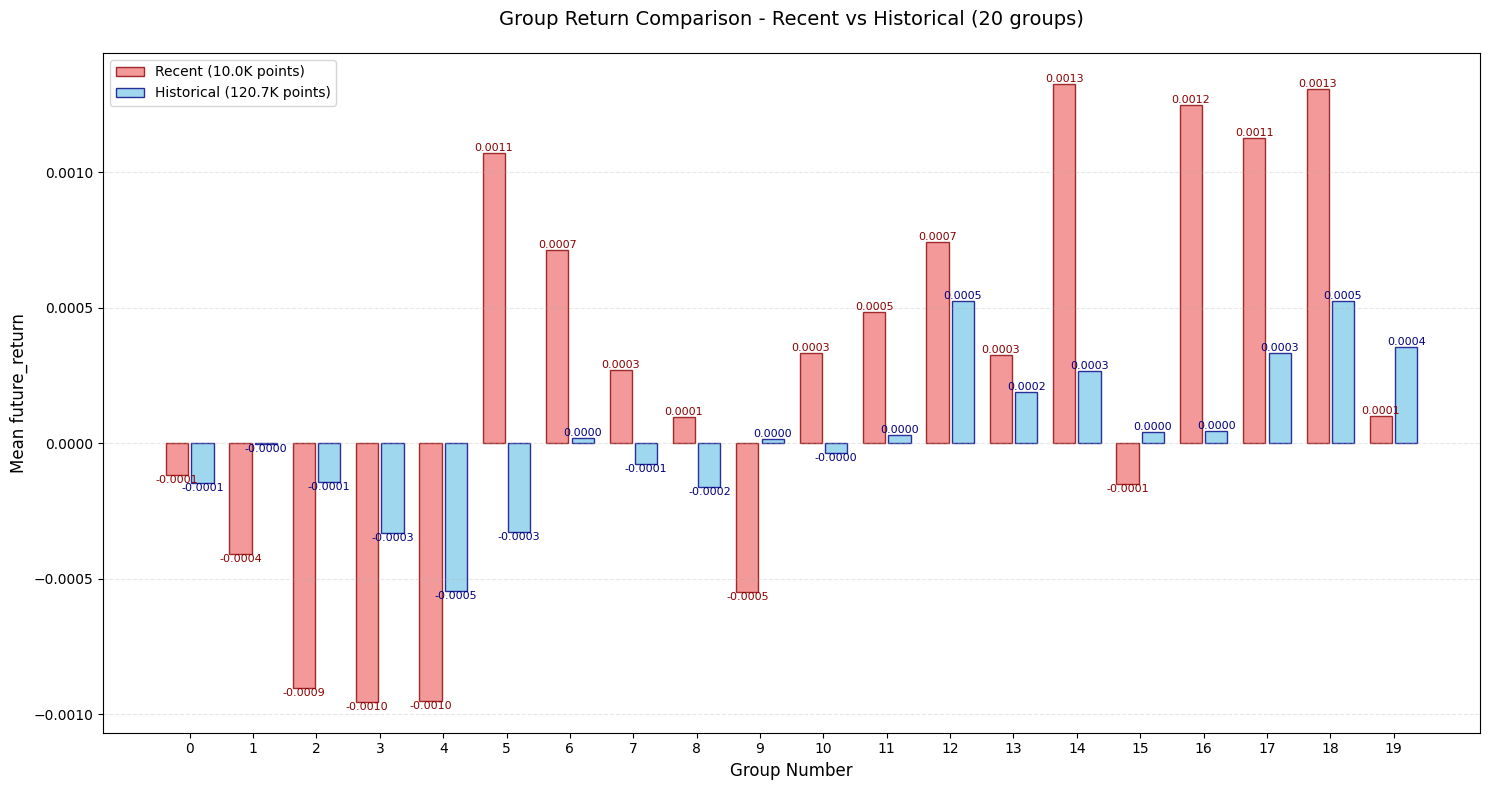

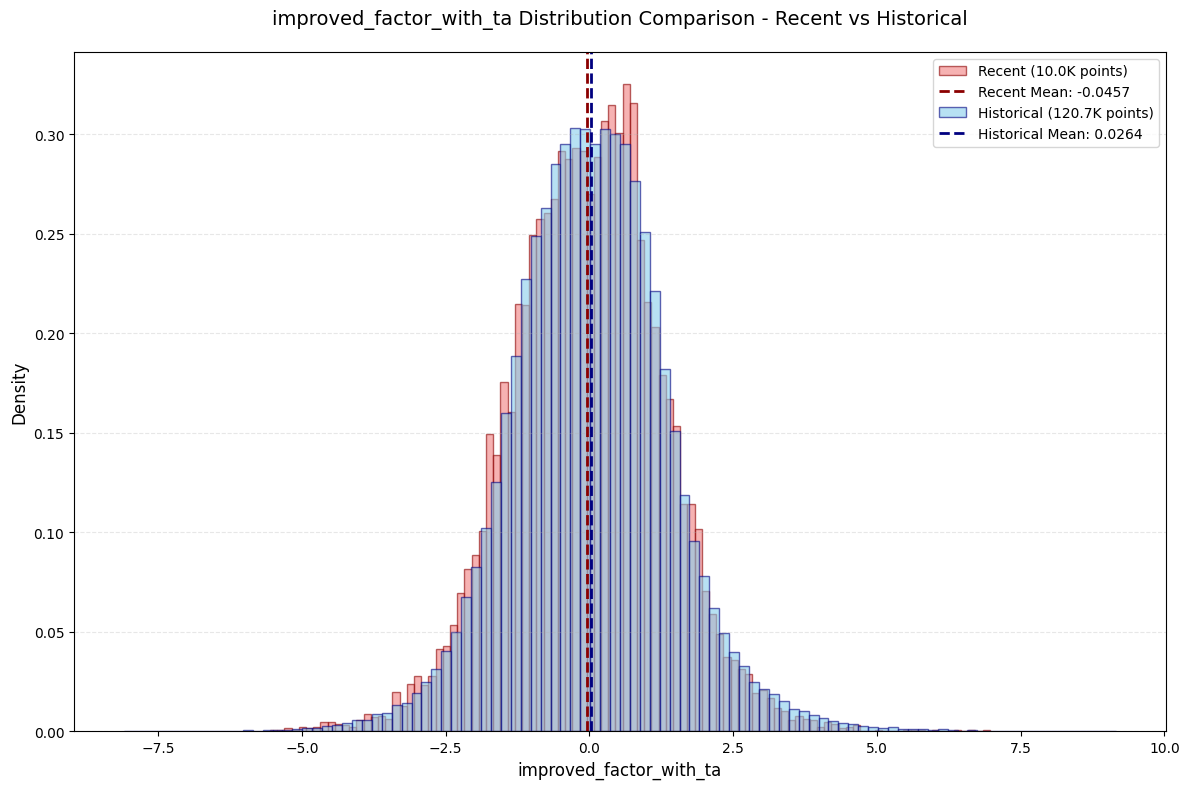

üìà ÊòæÁ§∫Âõ†Â≠êÂàÜÂ∏ÉÂõæ...
‚úÖ Â∑≤ÊòæÁ§∫ 2 ‰∏™ÂõæÁâá
----------------------------------------


In [18]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)